## Install dependencies and import

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [0]:
!pip install numpy
!pip install torch
!pip install matplotlib
!pip install scipy
!pip install torchvision
!pip install tqdm
!pip install visdom
!pip install nibabel
!pip install scikit-image
!pip install h5py
!pip install pandas
!pip install dominate
!pip install pydicom
!pip install opencv-python
!pip install scikit-learn
!pip install tensorflow
!pip install https://github.com/ozan-oktay/torchsample/tarball/master#egg=torchsample-0.1.3

     |████████████████████████████████| 686kB 3.5MB/s 
     |████████████████████████████████| 204kB 46.1MB/s 
  Created wheel for visdom: filename=visdom-0.1.8.9-cp36-none-any.whl size=655252 sha256=04b0ef15e2ae54fe1c5735a8ddfe7bfdf06e405a8f4ae3fcd7dfa2cf8eb99103
  Stored in directory: /root/.cache/pip/wheels/70/19/a7/6d589ed967f4dfefd33bc166d081257bd4ed0cb618dccfd62a
  Created wheel for torchfile: filename=torchfile-0.1.0-cp36-none-any.whl size=5711 sha256=5b9803b85827d3eb2185efa6836b4da779476a3739a6777c924f2b064b25e805
  Stored in directory: /root/.cache/pip/wheels/b1/c3/d6/9a1cc8f3a99a0fc1124cae20153f36af59a6e683daca0a0814
Successfully built visdom torchfile
     |████████████████████████████████| 7.1MB 3.1MB/s 
     \ 389kB 1.5MB/s
  Created wheel for torchsample: filename=torchsample-0.1.3-cp36-none-any.whl size=45258 sha256=5482148c202cae37b5a0b941e8ed81c9601d2191d887510dafc59ac957ffdcb8
  Stored in directory: /tmp/pip-ephem-wheel-cache-6kq_sdmb/wheels/c2/f9/43/f2601da3bddeee29b

In [0]:
import os
import shutil
import zipfile
import json
import collections
import torch.nn as nn
import torch
import torchvision
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pydicom
import numpy as np
import pandas as pd
import torch.optim as optim
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

## Setup dataset

In [0]:
# local machine directories
DATA_DIR = "/content/data/"
DATA_MASKS_DIR = DATA_DIR + "masks"
DATA_DICOM_DIR = DATA_DIR + "input"

# google drive directories
DATA_ZIP_FILE_PATH = "/content/gdrive/My Drive/mlmi/dataset/input.zip"
MASKS_DIR = "/content/gdrive/My Drive/mlmi/dataset/masks/"
TENSORBOARD_LOGS_DIR = "/content/gdrive/My Drive/mlmi/results/tensorboard/"
MODEL_SAVE_DIR = "/content/gdrive/My Drive/mlmi/results/model/"


Copy masks from gdrive

In [0]:
# create data directory locally
if os.path.exists(DATA_DIR) == False:
  os.makedirs(DATA_DIR)
  print("Create directory: " + DATA_DIR)

Create directory: /content/data/


In [0]:
if os.path.exists(DATA_MASKS_DIR):
  shutil.rmtree(DATA_MASKS_DIR)
  print("Deleted old masks directory: " + DATA_MASKS_DIR)

!cp -r "$MASKS_DIR" $DATA_DIR
%ls $DATA_MASKS_DIR

simm_DS_test.csv  simm_DS_train.csv  simm_DS_validation.csv  train-rle.csv


Extract DICOM files from zip

In [0]:
# only extract if input folder doesn't exists
if os.path.exists(DATA_DICOM_DIR) == False:
  #!unzip "$DATA_ZIP_FILE_PATH" -d "$DATA_DIR"
  zip_ref = zipfile.ZipFile(DATA_ZIP_FILE_PATH, 'r')
  zip_ref.extractall(DATA_DIR)
  zip_ref.close()
  print("Extracted dicom zip file to directory: " + DATA_DICOM_DIR)

%ls $DATA_DICOM_DIR
#%ls "$DATA_DICOM_DIR/siim/dicom-images-train"

Extracted dicom zip file to directory: /content/data/input
siim/


## Model Definitions

In [0]:
def init_weights(net, init_type='normal'):
    #print('initialization method [%s]' % init_type)
    if init_type == 'normal':
        net.apply(weights_init_normal)
    elif init_type == 'xavier':
        net.apply(weights_init_xavier)
    elif init_type == 'kaiming':
        net.apply(weights_init_kaiming)
    elif init_type == 'orthogonal':
        net.apply(weights_init_orthogonal)
    else:
        raise NotImplementedError('initialization method [%s] is not implemented' % init_type)

def weights_init_kaiming(m):
    classname = m.__class__.__name__
    #print(classname)
    if classname.find('Conv') != -1:
        nn.init.kaiming_normal(m.weight.data, a=0, mode='fan_in')
    elif classname.find('Linear') != -1:
        nn.init.kaiming_normal(m.weight.data, a=0, mode='fan_in')
    elif classname.find('BatchNorm') != -1:
        nn.init.normal(m.weight.data, 1.0, 0.02)
        nn.init.constant(m.bias.data, 0.0)
        
class unetConv2(nn.Module):
    def __init__(self, in_size, out_size, is_batchnorm, n=2, ks=3, stride=1, padding=1):
        super(unetConv2, self).__init__()
        self.n = n
        self.ks = ks
        self.stride = stride
        self.padding = padding
        s = stride
        p = padding
        if is_batchnorm:
            for i in range(1, n+1):
                conv = nn.Sequential(nn.Conv2d(in_size, out_size, ks, s, p),
                                     nn.BatchNorm2d(out_size),
                                     nn.ReLU(inplace=True),)
                setattr(self, 'conv%d'%i, conv)
                in_size = out_size

        else:
            for i in range(1, n+1):
                conv = nn.Sequential(nn.Conv2d(in_size, out_size, ks, s, p),
                                     nn.ReLU(inplace=True),)
                setattr(self, 'conv%d'%i, conv)
                in_size = out_size

        # initialise the blocks
        for m in self.children():
            init_weights(m, init_type='kaiming')

    def forward(self, inputs):
        x = inputs
        for i in range(1, self.n+1):
            conv = getattr(self, 'conv%d'%i)
            x = conv(x)

        return x

class unetUp2(nn.Module):
    def __init__(self, in_size, out_size, is_deconv, is_batchnorm=True):
        super(unetUp2, self).__init__()
        self.conv = unetConv2(in_size + out_size, out_size, is_batchnorm)
        if is_deconv:
            self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=4, stride=2, padding=1)
        else:
            self.up = nn.UpsamplingBilinear2d(scale_factor=2)

        # initialise the blocks
        for m in self.children():
            if m.__class__.__name__.find('unetConv2') != -1: continue
            init_weights(m, init_type='kaiming')

    def forward(self, inputs1, inputs2):
        outputs2 = self.up(inputs2)
        # offset = outputs2.size()[1] - inputs1.size()[1]
        # padding = [0, 0, 0, 0, offset // 2, offset // 2]
        # outputs1 = F.pad(inputs1, padding)
        outputs1 = inputs1
        cat = torch.cat([outputs1, outputs2], 1)
        return self.conv(cat)

class UnetGridGatingSignal2(nn.Module):
    def __init__(self, in_size, out_size, ks=1, is_batchnorm=True):
        super(UnetGridGatingSignal2, self).__init__()

        if is_batchnorm:
            self.conv1 = nn.Sequential(nn.Conv2d(in_size, out_size, ks),
                                       nn.BatchNorm2d(out_size),
                                       nn.ReLU(inplace=True),
                                       )
        else:
            self.conv1 = nn.Sequential(nn.Conv2d(in_size, out_size, ks),
                                       nn.ReLU(inplace=True),
                                       )

        # initialise the blocks
        for m in self.children():
            init_weights(m, init_type='kaiming')

    def forward(self, inputs):
        outputs = self.conv1(inputs)
        return outputs

class UnetDsv2(nn.Module):
    def __init__(self, in_size, out_size, scale_factor):
        super(UnetDsv2, self).__init__()
        self.dsv = nn.Sequential(nn.Conv2d(in_size, out_size, kernel_size=1, stride=1, padding=0),
                                 nn.Upsample(scale_factor=scale_factor, mode='bilinear'), )

    def forward(self, input):
        return self.dsv(input)

class _GridAttentionBlockND(nn.Module):
    def __init__(self, in_channels, gating_channels, inter_channels=None, dimension=3, mode='concatenation',
                 sub_sample_factor=(2,2,2)):
        super(_GridAttentionBlockND, self).__init__()

        assert dimension in [2, 3]
        assert mode in ['concatenation', 'concatenation_debug', 'concatenation_residual']

        # Downsampling rate for the input featuremap
        if isinstance(sub_sample_factor, tuple): self.sub_sample_factor = sub_sample_factor
        elif isinstance(sub_sample_factor, list): self.sub_sample_factor = tuple(sub_sample_factor)
        else: self.sub_sample_factor = tuple([sub_sample_factor]) * dimension

        # Default parameter set
        self.mode = mode
        self.dimension = dimension
        self.sub_sample_kernel_size = self.sub_sample_factor

        # Number of channels (pixel dimensions)
        self.in_channels = in_channels
        self.gating_channels = gating_channels
        self.inter_channels = inter_channels

        if self.inter_channels is None:
            self.inter_channels = in_channels // 2
            if self.inter_channels == 0:
                self.inter_channels = 1

        if dimension == 3:
            conv_nd = nn.Conv3d
            bn = nn.BatchNorm3d
            self.upsample_mode = 'trilinear'
        elif dimension == 2:
            conv_nd = nn.Conv2d
            bn = nn.BatchNorm2d
            self.upsample_mode = 'bilinear'
        else:
            raise NotImplemented

        # Output transform
        self.W = nn.Sequential(
            conv_nd(in_channels=self.in_channels, out_channels=self.in_channels, kernel_size=1, stride=1, padding=0),
            bn(self.in_channels),
        )

        # Theta^T * x_ij + Phi^T * gating_signal + bias
        self.theta = conv_nd(in_channels=self.in_channels, out_channels=self.inter_channels,
                             kernel_size=self.sub_sample_kernel_size, stride=self.sub_sample_factor, padding=0, bias=False)
        self.phi = conv_nd(in_channels=self.gating_channels, out_channels=self.inter_channels,
                           kernel_size=1, stride=1, padding=0, bias=True)
        self.psi = conv_nd(in_channels=self.inter_channels, out_channels=1, kernel_size=1, stride=1, padding=0, bias=True)

        # Initialise weights
        for m in self.children():
            init_weights(m, init_type='kaiming')

        # Define the operation
        if mode == 'concatenation':
            self.operation_function = self._concatenation
        elif mode == 'concatenation_debug':
            self.operation_function = self._concatenation_debug
        elif mode == 'concatenation_residual':
            self.operation_function = self._concatenation_residual
        else:
            raise NotImplementedError('Unknown operation function.')


    def forward(self, x, g):
        '''
        :param x: (b, c, t, h, w)
        :param g: (b, g_d)
        :return:
        '''

        output = self.operation_function(x, g)
        return output

    def _concatenation(self, x, g):
        input_size = x.size()
        batch_size = input_size[0]
        assert batch_size == g.size(0)

        # theta => (b, c, t, h, w) -> (b, i_c, t, h, w) -> (b, i_c, thw)
        # phi   => (b, g_d) -> (b, i_c)
        theta_x = self.theta(x)
        theta_x_size = theta_x.size()

        # g (b, c, t', h', w') -> phi_g (b, i_c, t', h', w')
        #  Relu(theta_x + phi_g + bias) -> f = (b, i_c, thw) -> (b, i_c, t/s1, h/s2, w/s3)
        phi_g = F.interpolate(self.phi(g), size=theta_x_size[2:], mode=self.upsample_mode)
        f = F.relu(theta_x + phi_g, inplace=True)

        #  psi^T * f -> (b, psi_i_c, t/s1, h/s2, w/s3)
        sigm_psi_f = torch.sigmoid(self.psi(f))

        # upsample the attentions and multiply
        sigm_psi_f = F.interpolate(sigm_psi_f, size=input_size[2:], mode=self.upsample_mode)
        y = sigm_psi_f.expand_as(x) * x
        W_y = self.W(y)

        return W_y, sigm_psi_f

class GridAttentionBlock2D(_GridAttentionBlockND):
    def __init__(self, in_channels, gating_channels, inter_channels=None, mode='concatenation',
                 sub_sample_factor=(2,2,2)):
        super(GridAttentionBlock2D, self).__init__(in_channels,
                                                   inter_channels=inter_channels,
                                                   gating_channels=gating_channels,
                                                   dimension=2, mode=mode,
                                                   sub_sample_factor=sub_sample_factor
                                                   )


class MultiAttentionBlock(nn.Module):
    def __init__(self, in_size, gate_size, inter_size, nonlocal_mode, sub_sample_factor):
        super(MultiAttentionBlock, self).__init__()
        self.gate_block_1 = GridAttentionBlock2D(in_channels=in_size, gating_channels=gate_size,
                                                 inter_channels=inter_size, mode=nonlocal_mode,
                                                 sub_sample_factor= sub_sample_factor)
        self.combine_gates = nn.Sequential(nn.Conv2d(in_size, in_size, kernel_size=1, stride=1, padding=0),
                                           nn.BatchNorm2d(in_size),
                                           nn.ReLU(inplace=True)
                                           )

        # initialise the blocks
        for m in self.children():
            if m.__class__.__name__.find('GridAttentionBlock2D') != -1: continue
            init_weights(m, init_type='kaiming')

    def forward(self, input, gating_signal):
        gate_1, attention_1 = self.gate_block_1(input, gating_signal)
        return self.combine_gates(gate_1), attention_1

In [0]:
class unet_simm(nn.Module):

    def __init__(self, feature_scale, n_classes, is_deconv, in_channels,
                 nonlocal_mode, attention_dsample, is_batchnorm):
        super(unet_simm, self).__init__()
        self.is_deconv = is_deconv
        self.in_channels = in_channels
        self.is_batchnorm = is_batchnorm
        self.feature_scale = feature_scale
        # self.use_cuda = Config.use_cuda

        filters = [64, 128, 256, 512, 1024]
        filters = [int(x / self.feature_scale) for x in filters]
        # filter [16, 32, 64, 128, 256]

        # downsampling
        self.conv1 = unetConv2(self.in_channels, filters[0], self.is_batchnorm, ks=3)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = unetConv2(filters[0], filters[1], self.is_batchnorm, ks=3)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)

        self.conv3 = unetConv2(filters[1], filters[2], self.is_batchnorm, ks=3)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)

        self.conv4 = unetConv2(filters[2], filters[3], self.is_batchnorm, ks=3)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2)

        self.center = unetConv2(filters[3], filters[4], self.is_batchnorm, ks=3)
        self.gating = UnetGridGatingSignal2(filters[4], filters[4], ks=1, is_batchnorm=self.is_batchnorm)

        # attention blocks
        self.attentionblock2 = MultiAttentionBlock(in_size=filters[1], gate_size=filters[2], inter_size=filters[1],
                                                   nonlocal_mode=nonlocal_mode, sub_sample_factor= attention_dsample)
        self.attentionblock3 = MultiAttentionBlock(in_size=filters[2], gate_size=filters[3], inter_size=filters[2],
                                                   nonlocal_mode=nonlocal_mode, sub_sample_factor= attention_dsample)
        self.attentionblock4 = MultiAttentionBlock(in_size=filters[3], gate_size=filters[4], inter_size=filters[3],
                                                   nonlocal_mode=nonlocal_mode, sub_sample_factor= attention_dsample)

        # upsampling
        self.up_concat4 = unetUp2(filters[4], filters[3], False, is_batchnorm)
        # self.up_concat4 = unetUp2(512, filters[3], False, is_batchnorm)
        self.up_concat3 = unetUp2(filters[3], filters[2], False, is_batchnorm)
        self.up_concat2 = unetUp2(filters[2], filters[1], False, is_batchnorm)
        self.up_concat1 = unetUp2(filters[1], filters[0], False, is_batchnorm)

        # deep supervision
        self.dsv4 = UnetDsv2(in_size=filters[3], out_size=n_classes, scale_factor=8)
        self.dsv3 = UnetDsv2(in_size=filters[2], out_size=n_classes, scale_factor=4)
        self.dsv2 = UnetDsv2(in_size=filters[1], out_size=n_classes, scale_factor=2)
        self.dsv1 = nn.Conv2d(in_channels=filters[0], out_channels=n_classes, kernel_size=1)

        # final conv (without any concat)
        self.final = nn.Conv2d(n_classes*4, n_classes, 1)

        # initialise weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init_weights(m, init_type='kaiming')
            elif isinstance(m, nn.BatchNorm2d):
                init_weights(m, init_type='kaiming')

    def forward(self, inputs):

        # if self.use_cuda == False:
        #     # inputs = inputs.to(dtype=torch.float64)
        #     inputs = inputs.double()

        # inputs = inputs.double()

        # Feature Extraction
        conv1 = self.conv1(inputs)
        maxpool1 = self.maxpool1(conv1)

        conv2 = self.conv2(maxpool1)
        maxpool2 = self.maxpool2(conv2)

        conv3 = self.conv3(maxpool2)
        maxpool3 = self.maxpool3(conv3)

        conv4 = self.conv4(maxpool3)
        maxpool4 = self.maxpool4(conv4)

        # Gating Signal Generation
        center = self.center(maxpool4)
        gating = self.gating(center)

        # Attention Mechanism
        # Upscaling Part (Decoder)
        g_conv4, att4 = self.attentionblock4(conv4, gating)
        up4 = self.up_concat4(g_conv4, center)
        g_conv3, att3 = self.attentionblock3(conv3, up4)
        up3 = self.up_concat3(g_conv3, up4)
        g_conv2, att2 = self.attentionblock2(conv2, up3)
        up2 = self.up_concat2(g_conv2, up3)
        up1 = self.up_concat1(conv1, up2)

        # Deep Supervision
        dsv4 = self.dsv4(up4)
        dsv3 = self.dsv3(up3)
        dsv2 = self.dsv2(up2)
        dsv1 = self.dsv1(up1)
        final = self.final(torch.cat([dsv1,dsv2,dsv3,dsv4], dim=1))

        final = torch.sigmoid(final)

        return final

In [0]:
def rle2mask(rle, width, height):
    mask= np.zeros(width* height)
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        current_position += start
        mask[current_position:current_position+lengths[index]] = 255
        current_position += lengths[index]

    return mask.reshape(width, height)
    
class SIMMDataset(Dataset):
    """SIMM dataset."""

    def __init__(self, root_dir, split, transform=None):
        """
        Args:
            dicomPaths (Array<string>): Array of DICOM file Paths.
            mask_csv_file (string): csv file with encoded masks (rle).
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """

        self.root_dir = root_dir
        self.dir_postfix = 'input/siim/'

        self.im_height = 1024
        self.im_width = 1024
        self.im_chan = 1

        ## Read masks file
        mask_csv_file = root_dir + 'masks/train-rle.csv' 
        print("Reading masks from: " + mask_csv_file)
        self.encodedMasks = pd.read_csv(mask_csv_file, names=['ImageId', 'EncodedPixels'], index_col='ImageId')

        ## Read dataset file names
        dsFile = root_dir + 'masks/simm_DS_' + split + '.csv'
        print("Reading ds from: " + dsFile)
        dsFileData = pd.read_csv(dsFile)
        self.dicomPaths = dsFileData['path'].tolist()
        print("READ")
        self.transform = transform

    def __len__(self):
        return len(self.dicomPaths)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        dPath = self.dicomPaths[idx]
        dicom = pydicom.dcmread(self.root_dir + self.dir_postfix + dPath)
        
#         image = np.zeros((1, im_height, im_width, im_chan), dtype=np.uint8)
#         image = np.expand_dims(dicom.pixel_array, axis=2)
        image = np.array(dicom.pixel_array)
        
        # get mask (in rle) from csv
        landmarks = np.zeros((self.im_height, self.im_width), dtype=np.bool)
        
        fileId = dPath.split('/')[-1][:-4]
        rle = self.encodedMasks.loc[fileId, 'EncodedPixels']
        try:
            if type(rle) == str: # if single rle
                decodedRle = rle2mask(rle, self.im_height, self.im_width)
#                 landmarks = np.expand_dims(decodedRle, axis=2)
                landmarks = decodedRle
            else: # if multiple rle
                for x in rle:
                    decodedRle = rle2mask(x, self.im_height, self.im_width)
                    landmarks = landmarks + decodedRle
#                     landmarks = landmarks + np.expand_dims(decodedRle, axis=2)
        except Exception as e:
            print(e)
            
        #### TODO - IMPORTANT::: CHECK THIS  
        ## QUESTION: SHOULD WE TRANSPOSE THE MASK IN THE GETITEM FUNCTION 
        ## BECAUSE WHEN PLOTING THE GRAPHS WE HAVE TO TRANSPOSE IT.
        landmarks = landmarks.T

        # for some images, we have multiple masks, so we are adding the masks
        # which results in some pixels to > 1
        landmarks = (landmarks >= 1).astype('float64')
            
        sample = {'image': image, 'mask': landmarks}

        if self.transform:
            sample = self.transform(sample)

        img = np.expand_dims(sample['image'], axis=0)
        mk = np.expand_dims(sample['mask'], axis=0)

        img = img / 255

        return img, mk

In [0]:
class SIMMSoftDiceLoss(nn.Module):
    def __init__(self):
        super(SIMMSoftDiceLoss, self).__init__()

    def forward(self, input, target):
        smooth = 0.01
        batch_size = input.size(0)

        # input = torch.sigmoid(input).view(batch_size, -1)
        input = input.view(batch_size, -1)
        target = target.contiguous().view(batch_size, -1)

        inter = torch.sum(input * target, 1) + smooth
        union = torch.sum(input, 1) + torch.sum(target, 1) + smooth

        score = torch.sum(2.0 * inter / union, 0)
        score = 1.0 - score / float(batch_size)
        
        return score

In [0]:
def json_file_to_pyobj(jsonStr):
    def _json_object_hook(d): return collections.namedtuple('X', d.keys())(*d.values())
    def json2obj(data): return json.loads(data, object_hook=_json_object_hook)
    return json2obj(jsonStr)

In [0]:
def create_checkpoint(model, epoch_loss, epoch, network_options, dir_prefix):
    """
    Saves checkpoint of torchvision model during training.

    Args:
        model: torchvision model to be saved
        epoch_loss: best val loss achieved so far in training
        epoch: current epoch of training
        network_options: includes information if batchsize, lr etc.
    Returns:
        None
    """

    print('Saving model checkpoint')
    state = {
        'model': model,
        'epoch_loss': epoch_loss,
        'epoch': epoch,
        'rng_state': torch.get_rng_state(),
        'network_options': network_options
    }

    torch.save(state, os.path.join(MODEL_SAVE_DIR, dir_prefix, 'checkpoint'+str(epoch)+'.m'))

## Model Training

In [0]:
## Model Hyperparameters

NETWORK_OPTIONS = dict()
NETWORK_OPTIONS['USE_CUDA'] = False

NETWORK_OPTIONS['LR_POLICY'] = "step"
NETWORK_OPTIONS['LR_DECAY_ITERS'] = 25
NETWORK_OPTIONS['LR_RATE'] = 1e-3
NETWORK_OPTIONS['L2_REG_WEIGHT'] = 1e-6

NETWORK_OPTIONS['BATCH_SIZE'] = 4

NETWORK_OPTIONS['CONTINUE_TRAIN'] = False
NETWORK_OPTIONS['START_EPOCH'] = 0
NETWORK_OPTIONS['NUM_EPOCHS'] = 50

NETWORK_OPTIONS['FEATURE_SCALE'] = 4
NETWORK_OPTIONS['DIVISION_FACTOR'] = 1

NETWORK_OPTIONS['DATALOADER_NUM_WORKERS'] = 2
NETWORK_OPTIONS['DATA_DIR'] = DATA_DIR
NETWORK_OPTIONS['TENSORBOARD_LOGS_DIR'] = TENSORBOARD_LOGS_DIR
NETWORK_OPTIONS['MODEL_SAVE_DIR'] = MODEL_SAVE_DIR

# converting dict() to python object (just for easy access)
NETWORK_OPTIONS_OBJ = json_file_to_pyobj(json.dumps(NETWORK_OPTIONS))

In [0]:
# json_opts = {
#   "use_cuda": True,
#   "network_debug": 0,
#   "training": {
#     "arch_type": "simm_unet",
#     "n_epochs": 50,
#     "save_epoch_freq": 10,
#     "lr_policy": "step",
#     "lr_decay_iters": 25,
#     "batchSize": 4,
#     "preloadData": True,
#     "network_debug": 0
#   },
#   "visualisation":{
#     "display_port": 6006,
#     "display_server": "http://54.89.248.230",
#     "no_html": True,
#     "display_winsize": 256,
#     "display_id": 1,
#     "display_single_pane_ncols": 0
#   },
#   "data_path": {
#     "simm_unet": "/content/data",
#     "postfix": "/input/siim/"
#   },
#   "augmentation": {
#   },
#   "model":{
#     "type":"seg",
#     "continue_train": False,
#     "which_epoch": -1,
#     "model_type": "unet_simm",
#     "tensor_dim": "2D",
#     "division_factor": 16,
#     "input_nc": 1,
#     "output_nc": 1,
#     "lr_rate": 1e-4,
#     "l2_reg_weight": 1e-6,
#     "feature_scale": 2,
#     "gpu_ids": [],
#     "isTrain": True,
#     "checkpoints_dir": "./checkpoints",
#     "experiment_name": "experiment_unet_simm",
#     "criterion": "SIMMSoftDiceLoss",
#     "optim": "adam",
#     "n_classes": 1
#   }
# }

# import json
# import collections
# def json_file_to_pyobj(jsonStr):
#     def _json_object_hook(d): return collections.namedtuple('X', d.keys())(*d.values())
#     def json2obj(data): return json.loads(data, object_hook=_json_object_hook)
#     return json2obj(jsonStr)

# json_opts = json_file_to_pyobj(json.dumps(json_opts))
# train_opts = json_opts.training
# model_opts = json_opts.model

In [0]:
# Defining Dataloaders

# ds_transform = get_dataset_transformation(arch_type, opts=json_opts.augmentation)

train_dataset = SIMMDataset(NETWORK_OPTIONS_OBJ.DATA_DIR, split='train', transform=None)
valid_dataset = SIMMDataset(NETWORK_OPTIONS_OBJ.DATA_DIR, split='validation', transform=None)
# test_dataset  = SIMMDataset(ds_path, split='test', transform=None)

train_loader = DataLoader(dataset=train_dataset, num_workers=NETWORK_OPTIONS_OBJ.DATALOADER_NUM_WORKERS, batch_size=NETWORK_OPTIONS_OBJ.BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, num_workers=NETWORK_OPTIONS_OBJ.DATALOADER_NUM_WORKERS, batch_size=NETWORK_OPTIONS_OBJ.BATCH_SIZE, shuffle=False)
# test_loader  = DataLoader(dataset=test_dataset,  num_workers=numWorkers, batch_size=train_opts.batchSize, shuffle=False)

Reading masks from: /content/data/masks/train-rle.csv
Reading ds from: /content/data/masks/simm_DS_train.csv
READ
Reading masks from: /content/data/masks/train-rle.csv
Reading ds from: /content/data/masks/simm_DS_validation.csv
READ


In [0]:
if torch.cuda.is_available():
  gpu_count = torch.cuda.device_count()
  print("Available GPU count:" + str(gpu_count))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

Available GPU count:1
cuda:0


In [0]:
# Setup the NN Model
# (self, feature_scale=4, n_classes=21, is_deconv=True, in_channels=3,
#                  nonlocal_mode='concatenation', attention_dsample=(2,2,2), is_batchnorm=True)

model = unet_simm(n_classes=1,
                      is_batchnorm=True,
                      in_channels=1,
                      nonlocal_mode='concatenation',
                      feature_scale=NETWORK_OPTIONS_OBJ.FEATURE_SCALE,
                      attention_dsample=(2,2),
                      is_deconv=False)
model = model.to(device)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.


In [0]:
# model.load_state_dict(torch.load("/content/gdrive/My Drive/mlmi/results/model_simm_1.pth"))

In [0]:
%load_ext tensorboard
%tensorboard --logdir="$NETWORK_OPTIONS_OBJ.TENSORBOARD_LOGS_DIR"
# %reload_ext tensorboard

torch.Size([4, 1, 1024, 1024])
torch.Size([3, 1028, 4106])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


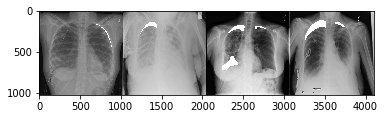

In [0]:
def get_images_grid(images):
  img_grid = torchvision.utils.make_grid(images, nrow=4)
  img_grid = img_grid.numpy()
  return np.transpose(img_grid, (1, 2, 0))

def show_image(images, labels):
  imgs = images.clone()

  imgs[labels == 1] = 255
  imgs[predictions >= 0.5] = 200

  imgs_grid = get_images_grid(imgs) 

  plt.imshow(imgs_grid, cmap=plt.cm.bone)
  plt.show()
  del imgs

def show_images_with_masks(images, labels):
  imgs_grid = get_images_grid(images)
  lbls_grid = get_images_grid(labels)

  plt.imshow(imgs_grid, cmap=plt.cm.bone)
  plt.imshow(lbls_grid, alpha=0.3, cmap="Reds")
  plt.show()

def show_images_with_masks_and_prediction(images, labels, predictions):
  imgs = images.clone()

  imgs[labels == 1] = 255
  imgs[predictions >= 0.5] = 200

  imgs_grid = get_images_grid(imgs) 

  plt.imshow(imgs_grid, cmap=plt.cm.bone)
  plt.show()
  del imgs

def matplotlib_imshow(img, one_channel=False):
  # if one_channel:
  #     img = img.mean(dim=0)
  # img = img / 2 + 0.5     # unnormalize
  npimg = img.numpy()
  if one_channel:
      plt.imshow(npimg, cmap=plt.cm.bone)
  else:
      plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(train_loader)
sample_images, sample_labels = dataiter.next()

ims = sample_images.clone()
ims[sample_labels == 1] = 255

# create grid of images
print(ims.shape)
img_grid = torchvision.utils.make_grid(ims)
print(img_grid.shape)

matplotlib_imshow(img_grid, one_channel=False)


In [0]:
import torch
torch.cuda.empty_cache()

In [0]:
import time
timestr = time.strftime("%Y%m%d-%H%M%S")
print(timestr)

criterion = SIMMSoftDiceLoss()
optimizer = optim.Adam(model.parameters(),
                        lr=NETWORK_OPTIONS_OBJ.LR_RATE,
                        betas=(0.9, 0.999),
                        weight_decay=NETWORK_OPTIONS_OBJ.L2_REG_WEIGHT)

# optimizer = optim.SGD(params,
#                               lr=option.lr_rate,
#                               momentum=0.9,
#                               nesterov=True,
#                               weight_decay=option.l2_reg_weight)

tb_log_dir = NETWORK_OPTIONS_OBJ.TENSORBOARD_LOGS_DIR + 'run_' + timestr

tb = SummaryWriter(flush_secs=3, log_dir=tb_log_dir)

tb.add_scalar("learning_rate", NETWORK_OPTIONS_OBJ.LR_RATE)
tb.add_scalar("batch_size", NETWORK_OPTIONS_OBJ.BATCH_SIZE)

tb.add_image('siim_sample_images', img_grid)

# tb.add_graph(model, sample_images)

tb.flush()

# Training Function
# model.set_scheduler(train_opts)
for epoch in range(NETWORK_OPTIONS_OBJ.START_EPOCH, NETWORK_OPTIONS_OBJ.NUM_EPOCHS):
  print('############# Running epoch: %d...\n' % (epoch))

  # Training Iterations
  running_loss = 0.0
  loss_per_epoch = 0.0
  epoch_batch_count = 0

  total_iter = total=len(train_loader)
  for epoch_iter, (images, labels) in tqdm(enumerate(train_loader, 1), total=total_iter):
    # Make a training update
    inputs = images.float().to(device)
    masks = labels.to(device)
    # assert input.size() == target.size()

    # forward + backward + optimize
    outputs = model(inputs)
    loss = criterion(outputs, masks)

    # zero the parameter gradients
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # update losses for epoch
    loss_per_epoch += loss.item()
    epoch_batch_count += 1
    # print statistics
    running_loss += loss.item()
    if epoch_iter % 20 == 0:
      #show_images_with_masks_and_prediction(images, labels, outputs)

      loss_avg = running_loss / 20
      #print('[%d, %5d] Running loss: %.3f' % (epoch + 1, epoch_iter + 1, loss_avg))
      # (10 * x + y) / 10
      i_num = (epoch + 1) + ((epoch_iter + 1) / total_iter)
      tb.add_scalar('RunningLoss', loss_avg, i_num)
      running_loss = 0.0

  loss = loss_per_epoch / epoch_batch_count
  tb.add_scalar('Loss', loss, epoch + 1)
  print('*********** [%d] Loss per epoch: %.3f' %(epoch + 1, loss))

  # reset loss per epoch
  loss_per_epoch = 0.0
  epoch_batch_count = 0

  # Validation Iterations
  running_loss_valid = 0.0
  loss_per_epoch_valid = 0.0
  epoch_batch_count_valid = 0

  with torch.no_grad():
    for epoch_iter, (images, labels) in tqdm(enumerate(valid_loader, 1), total=len(valid_loader)):
      # get batch
      inputs = images.float().to(device)
      masks = labels.to(device)
      # assert input.size() == target.size()

      # forward
      outputs = model(inputs)
      loss = criterion(outputs, masks)

      # update losses for epoch
      loss_per_epoch_valid += loss.item()
      epoch_batch_count_valid += 1
      running_loss_valid += loss.item()

      if epoch_iter % 20 == 0:
        loss_avg = running_loss_valid / 20
        print('[%d, %5d] Running loss Validation: %.3f' % (epoch + 1, epoch_iter + 1, loss_avg))
        # (10 * x + y) / 10
        i_num = (10 * (epoch + 1) + (epoch_iter + 1)) - 10
        tb.add_scalar('RunningLossValidation', loss_avg, i_num)
        running_loss_valid = 0.0

  loss_valid = loss_per_epoch_valid / epoch_batch_count_valid
  tb.add_scalar('LossValidation', loss_valid, epoch + 1)
  print('*********** [%d] Validation Loss per epoch: %.3f' %(epoch + 1, loss_valid))

  # reset validation loss per epoch
  loss_per_epoch_valid = 0.0
  epoch_batch_count_valid = 0
  tb.flush()

  
  # Update the model learning rate
  # model.update_learning_rate()
tb.close()

20191219-072618


############# Running epoch: 0...



  0%|          | 0/400 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
100%|██████████| 400/400 [15:21<00:00,  2.30s/it]

*********** [1] Loss per epoch: 0.851



 15%|█▌        | 20/133 [00:16<01:32,  1.22it/s]

[1,    21] Running loss Validation: 0.802


 30%|███       | 40/133 [00:33<01:15,  1.23it/s]

[1,    41] Running loss Validation: 0.783


 45%|████▌     | 60/133 [00:49<00:59,  1.22it/s]

[1,    61] Running loss Validation: 0.791


 60%|██████    | 80/133 [01:06<00:43,  1.22it/s]

[1,    81] Running loss Validation: 0.773


 75%|███████▌  | 100/133 [01:22<00:27,  1.22it/s]

[1,   101] Running loss Validation: 0.786


 90%|█████████ | 120/133 [01:39<00:10,  1.22it/s]

[1,   121] Running loss Validation: 0.775


100%|██████████| 133/133 [01:49<00:00,  1.22it/s]

*********** [1] Validation Loss per epoch: 0.784
############# Running epoch: 1...




100%|██████████| 400/400 [15:23<00:00,  2.31s/it]

*********** [2] Loss per epoch: 0.776



 15%|█▌        | 20/133 [00:16<01:32,  1.22it/s]

[2,    21] Running loss Validation: 0.787


 30%|███       | 40/133 [00:33<01:16,  1.22it/s]

[2,    41] Running loss Validation: 0.756


 45%|████▌     | 60/133 [00:49<00:59,  1.22it/s]

[2,    61] Running loss Validation: 0.781


 60%|██████    | 80/133 [01:06<00:43,  1.22it/s]

[2,    81] Running loss Validation: 0.742


 75%|███████▌  | 100/133 [01:22<00:27,  1.21it/s]

[2,   101] Running loss Validation: 0.761


 90%|█████████ | 120/133 [01:39<00:10,  1.21it/s]

[2,   121] Running loss Validation: 0.738


100%|██████████| 133/133 [01:49<00:00,  1.22it/s]

*********** [2] Validation Loss per epoch: 0.758
############# Running epoch: 2...




100%|██████████| 400/400 [15:23<00:00,  2.31s/it]

*********** [3] Loss per epoch: 0.753



 15%|█▌        | 20/133 [00:16<01:32,  1.22it/s]

[3,    21] Running loss Validation: 0.795


 30%|███       | 40/133 [00:33<01:16,  1.22it/s]

[3,    41] Running loss Validation: 0.761


 45%|████▌     | 60/133 [00:49<00:59,  1.22it/s]

[3,    61] Running loss Validation: 0.794


 60%|██████    | 80/133 [01:06<00:43,  1.22it/s]

[3,    81] Running loss Validation: 0.730


 75%|███████▌  | 100/133 [01:22<00:27,  1.22it/s]

[3,   101] Running loss Validation: 0.751


 90%|█████████ | 120/133 [01:39<00:10,  1.21it/s]

[3,   121] Running loss Validation: 0.757


100%|██████████| 133/133 [01:50<00:00,  1.21it/s]

*********** [3] Validation Loss per epoch: 0.761
############# Running epoch: 3...




100%|██████████| 400/400 [15:23<00:00,  2.30s/it]

*********** [4] Loss per epoch: 0.731



 15%|█▌        | 20/133 [00:16<01:32,  1.22it/s]

[4,    21] Running loss Validation: 0.754


 30%|███       | 40/133 [00:33<01:16,  1.21it/s]

[4,    41] Running loss Validation: 0.738


 45%|████▌     | 60/133 [00:49<01:00,  1.21it/s]

[4,    61] Running loss Validation: 0.745


 60%|██████    | 80/133 [01:06<00:43,  1.22it/s]

[4,    81] Running loss Validation: 0.718


 75%|███████▌  | 100/133 [01:22<00:27,  1.22it/s]

[4,   101] Running loss Validation: 0.713


 90%|█████████ | 120/133 [01:39<00:10,  1.22it/s]

[4,   121] Running loss Validation: 0.711


100%|██████████| 133/133 [01:49<00:00,  1.22it/s]

*********** [4] Validation Loss per epoch: 0.728
############# Running epoch: 4...




100%|██████████| 400/400 [15:20<00:00,  2.31s/it]

*********** [5] Loss per epoch: 0.714



 15%|█▌        | 20/133 [00:16<01:32,  1.22it/s]

[5,    21] Running loss Validation: 0.748


 30%|███       | 40/133 [00:33<01:16,  1.22it/s]

[5,    41] Running loss Validation: 0.728


 45%|████▌     | 60/133 [00:49<00:59,  1.22it/s]

[5,    61] Running loss Validation: 0.750


 60%|██████    | 80/133 [01:06<00:43,  1.22it/s]

[5,    81] Running loss Validation: 0.729


 75%|███████▌  | 100/133 [01:22<00:27,  1.22it/s]

[5,   101] Running loss Validation: 0.714


 90%|█████████ | 120/133 [01:39<00:10,  1.22it/s]

[5,   121] Running loss Validation: 0.711


100%|██████████| 133/133 [01:50<00:00,  1.21it/s]

*********** [5] Validation Loss per epoch: 0.729
############# Running epoch: 5...




100%|██████████| 400/400 [15:23<00:00,  2.31s/it]

*********** [6] Loss per epoch: 0.699



 15%|█▌        | 20/133 [00:16<01:33,  1.21it/s]

[6,    21] Running loss Validation: 0.745


 30%|███       | 40/133 [00:33<01:16,  1.21it/s]

[6,    41] Running loss Validation: 0.717


 45%|████▌     | 60/133 [00:49<01:00,  1.20it/s]

[6,    61] Running loss Validation: 0.737


 60%|██████    | 80/133 [01:06<00:43,  1.21it/s]

[6,    81] Running loss Validation: 0.707


 75%|███████▌  | 100/133 [01:22<00:26,  1.22it/s]

[6,   101] Running loss Validation: 0.695


 90%|█████████ | 120/133 [01:39<00:10,  1.22it/s]

[6,   121] Running loss Validation: 0.709


100%|██████████| 133/133 [01:49<00:00,  1.23it/s]

*********** [6] Validation Loss per epoch: 0.718
############# Running epoch: 6...




100%|██████████| 400/400 [15:22<00:00,  2.30s/it]

*********** [7] Loss per epoch: 0.679



 15%|█▌        | 20/133 [00:16<01:32,  1.22it/s]

[7,    21] Running loss Validation: 0.718


 30%|███       | 40/133 [00:33<01:16,  1.22it/s]

[7,    41] Running loss Validation: 0.719


 45%|████▌     | 60/133 [00:49<00:59,  1.22it/s]

[7,    61] Running loss Validation: 0.730


 60%|██████    | 80/133 [01:06<00:43,  1.22it/s]

[7,    81] Running loss Validation: 0.714


 75%|███████▌  | 100/133 [01:22<00:27,  1.22it/s]

[7,   101] Running loss Validation: 0.703


 90%|█████████ | 120/133 [01:39<00:10,  1.22it/s]

[7,   121] Running loss Validation: 0.713


100%|██████████| 133/133 [01:49<00:00,  1.21it/s]

*********** [7] Validation Loss per epoch: 0.717
############# Running epoch: 7...




100%|██████████| 400/400 [15:23<00:00,  2.31s/it]

*********** [8] Loss per epoch: 0.665



 15%|█▌        | 20/133 [00:16<01:33,  1.21it/s]

[8,    21] Running loss Validation: 0.693


 30%|███       | 40/133 [00:33<01:16,  1.21it/s]

[8,    41] Running loss Validation: 0.674


 45%|████▌     | 60/133 [00:49<01:00,  1.21it/s]

[8,    61] Running loss Validation: 0.681


 60%|██████    | 80/133 [01:06<00:43,  1.21it/s]

[8,    81] Running loss Validation: 0.649


 75%|███████▌  | 100/133 [01:22<00:27,  1.22it/s]

[8,   101] Running loss Validation: 0.656


 90%|█████████ | 120/133 [01:39<00:10,  1.22it/s]

[8,   121] Running loss Validation: 0.646


100%|██████████| 133/133 [01:50<00:00,  1.22it/s]

*********** [8] Validation Loss per epoch: 0.670
############# Running epoch: 8...




100%|██████████| 400/400 [15:21<00:00,  2.29s/it]

*********** [9] Loss per epoch: 0.655



 15%|█▌        | 20/133 [00:16<01:32,  1.22it/s]

[9,    21] Running loss Validation: 0.715


 30%|███       | 40/133 [00:33<01:16,  1.22it/s]

[9,    41] Running loss Validation: 0.700


 45%|████▌     | 60/133 [00:49<00:59,  1.22it/s]

[9,    61] Running loss Validation: 0.722


 60%|██████    | 80/133 [01:06<00:43,  1.22it/s]

[9,    81] Running loss Validation: 0.679


 75%|███████▌  | 100/133 [01:22<00:27,  1.22it/s]

[9,   101] Running loss Validation: 0.675


 90%|█████████ | 120/133 [01:39<00:10,  1.22it/s]

[9,   121] Running loss Validation: 0.673


100%|██████████| 133/133 [01:50<00:00,  1.22it/s]

*********** [9] Validation Loss per epoch: 0.693
############# Running epoch: 9...




100%|██████████| 400/400 [15:24<00:00,  2.31s/it]

*********** [10] Loss per epoch: 0.642



 15%|█▌        | 20/133 [00:16<01:34,  1.20it/s]

[10,    21] Running loss Validation: 0.691


 30%|███       | 40/133 [00:33<01:16,  1.21it/s]

[10,    41] Running loss Validation: 0.676


 45%|████▌     | 60/133 [00:50<01:00,  1.20it/s]

[10,    61] Running loss Validation: 0.679


 60%|██████    | 80/133 [01:06<00:43,  1.22it/s]

[10,    81] Running loss Validation: 0.658


 75%|███████▌  | 100/133 [01:23<00:27,  1.22it/s]

[10,   101] Running loss Validation: 0.650


 90%|█████████ | 120/133 [01:39<00:10,  1.22it/s]

[10,   121] Running loss Validation: 0.646


100%|██████████| 133/133 [01:50<00:00,  1.22it/s]

*********** [10] Validation Loss per epoch: 0.668
############# Running epoch: 10...




100%|██████████| 400/400 [15:22<00:00,  2.30s/it]

*********** [11] Loss per epoch: 0.631



 15%|█▌        | 20/133 [00:16<01:32,  1.22it/s]

[11,    21] Running loss Validation: 0.671


 30%|███       | 40/133 [00:33<01:16,  1.22it/s]

[11,    41] Running loss Validation: 0.658


 45%|████▌     | 60/133 [00:49<00:59,  1.22it/s]

[11,    61] Running loss Validation: 0.649


 60%|██████    | 80/133 [01:06<00:43,  1.22it/s]

[11,    81] Running loss Validation: 0.634


 75%|███████▌  | 100/133 [01:22<00:27,  1.21it/s]

[11,   101] Running loss Validation: 0.635


 90%|█████████ | 120/133 [01:39<00:10,  1.22it/s]

[11,   121] Running loss Validation: 0.643


100%|██████████| 133/133 [01:50<00:00,  1.21it/s]

*********** [11] Validation Loss per epoch: 0.650
############# Running epoch: 11...




100%|██████████| 400/400 [15:24<00:00,  2.31s/it]

*********** [12] Loss per epoch: 0.615



 15%|█▌        | 20/133 [00:16<01:33,  1.21it/s]

[12,    21] Running loss Validation: 0.666


 30%|███       | 40/133 [00:33<01:16,  1.21it/s]

[12,    41] Running loss Validation: 0.679


 45%|████▌     | 60/133 [00:49<00:59,  1.22it/s]

[12,    61] Running loss Validation: 0.627


 60%|██████    | 80/133 [01:06<00:43,  1.22it/s]

[12,    81] Running loss Validation: 0.633


 75%|███████▌  | 100/133 [01:22<00:27,  1.21it/s]

[12,   101] Running loss Validation: 0.635


 90%|█████████ | 120/133 [01:39<00:10,  1.21it/s]

[12,   121] Running loss Validation: 0.626


100%|██████████| 133/133 [01:50<00:00,  1.22it/s]

*********** [12] Validation Loss per epoch: 0.648
############# Running epoch: 12...




100%|██████████| 400/400 [15:22<00:00,  2.29s/it]

*********** [13] Loss per epoch: 0.604



 15%|█▌        | 20/133 [00:16<01:32,  1.22it/s]

[13,    21] Running loss Validation: 0.662


 30%|███       | 40/133 [00:33<01:16,  1.22it/s]

[13,    41] Running loss Validation: 0.655


 45%|████▌     | 60/133 [00:49<00:59,  1.22it/s]

[13,    61] Running loss Validation: 0.660


 60%|██████    | 80/133 [01:06<00:43,  1.22it/s]

[13,    81] Running loss Validation: 0.638


 75%|███████▌  | 100/133 [01:22<00:27,  1.22it/s]

[13,   101] Running loss Validation: 0.615


 90%|█████████ | 120/133 [01:39<00:10,  1.22it/s]

[13,   121] Running loss Validation: 0.632


100%|██████████| 133/133 [01:49<00:00,  1.21it/s]

*********** [13] Validation Loss per epoch: 0.648
############# Running epoch: 13...




100%|██████████| 400/400 [15:24<00:00,  2.31s/it]

*********** [14] Loss per epoch: 0.597



 15%|█▌        | 20/133 [00:16<01:33,  1.21it/s]

[14,    21] Running loss Validation: 0.650


 30%|███       | 40/133 [00:33<01:17,  1.21it/s]

[14,    41] Running loss Validation: 0.633


 45%|████▌     | 60/133 [00:50<01:00,  1.21it/s]

[14,    61] Running loss Validation: 0.644


 60%|██████    | 80/133 [01:06<00:43,  1.22it/s]

[14,    81] Running loss Validation: 0.612


 75%|███████▌  | 100/133 [01:23<00:27,  1.22it/s]

[14,   101] Running loss Validation: 0.589


 90%|█████████ | 120/133 [01:39<00:10,  1.21it/s]

[14,   121] Running loss Validation: 0.619


100%|██████████| 133/133 [01:50<00:00,  1.22it/s]

*********** [14] Validation Loss per epoch: 0.626
############# Running epoch: 14...




100%|██████████| 400/400 [15:22<00:00,  2.31s/it]

*********** [15] Loss per epoch: 0.584



 15%|█▌        | 20/133 [00:16<01:32,  1.22it/s]

[15,    21] Running loss Validation: 0.656


 30%|███       | 40/133 [00:33<01:16,  1.21it/s]

[15,    41] Running loss Validation: 0.630


 45%|████▌     | 60/133 [00:49<01:00,  1.21it/s]

[15,    61] Running loss Validation: 0.620


 60%|██████    | 80/133 [01:06<00:43,  1.21it/s]

[15,    81] Running loss Validation: 0.625


 75%|███████▌  | 100/133 [01:23<00:27,  1.22it/s]

[15,   101] Running loss Validation: 0.616


 90%|█████████ | 120/133 [01:39<00:10,  1.22it/s]

[15,   121] Running loss Validation: 0.611


100%|██████████| 133/133 [01:50<00:00,  1.21it/s]

*********** [15] Validation Loss per epoch: 0.629
############# Running epoch: 15...




100%|██████████| 400/400 [15:23<00:00,  2.31s/it]

*********** [16] Loss per epoch: 0.581



 15%|█▌        | 20/133 [00:16<01:34,  1.20it/s]

[16,    21] Running loss Validation: 0.647


 30%|███       | 40/133 [00:33<01:16,  1.21it/s]

[16,    41] Running loss Validation: 0.633


 45%|████▌     | 60/133 [00:49<01:00,  1.22it/s]

[16,    61] Running loss Validation: 0.626


 60%|██████    | 80/133 [01:06<00:43,  1.22it/s]

[16,    81] Running loss Validation: 0.617


 75%|███████▌  | 100/133 [01:22<00:27,  1.21it/s]

[16,   101] Running loss Validation: 0.591


 90%|█████████ | 120/133 [01:39<00:10,  1.21it/s]

[16,   121] Running loss Validation: 0.606


100%|██████████| 133/133 [01:50<00:00,  1.22it/s]

*********** [16] Validation Loss per epoch: 0.623
############# Running epoch: 16...




100%|██████████| 400/400 [15:22<00:00,  2.29s/it]

*********** [17] Loss per epoch: 0.565



 15%|█▌        | 20/133 [00:16<01:33,  1.21it/s]

[17,    21] Running loss Validation: 0.635


 30%|███       | 40/133 [00:33<01:16,  1.22it/s]

[17,    41] Running loss Validation: 0.641


 45%|████▌     | 60/133 [00:50<01:00,  1.21it/s]

[17,    61] Running loss Validation: 0.627


 60%|██████    | 80/133 [01:06<00:43,  1.22it/s]

[17,    81] Running loss Validation: 0.596


 75%|███████▌  | 100/133 [01:23<00:27,  1.22it/s]

[17,   101] Running loss Validation: 0.601


 90%|█████████ | 120/133 [01:39<00:10,  1.21it/s]

[17,   121] Running loss Validation: 0.603


100%|██████████| 133/133 [01:50<00:00,  1.21it/s]

*********** [17] Validation Loss per epoch: 0.618
############# Running epoch: 17...




100%|██████████| 400/400 [15:24<00:00,  2.31s/it]

*********** [18] Loss per epoch: 0.560



 15%|█▌        | 20/133 [00:16<01:33,  1.21it/s]

[18,    21] Running loss Validation: 0.628


 30%|███       | 40/133 [00:33<01:16,  1.22it/s]

[18,    41] Running loss Validation: 0.622


 45%|████▌     | 60/133 [00:49<01:00,  1.21it/s]

[18,    61] Running loss Validation: 0.615


 60%|██████    | 80/133 [01:06<00:44,  1.20it/s]

[18,    81] Running loss Validation: 0.595


 75%|███████▌  | 100/133 [01:23<00:27,  1.21it/s]

[18,   101] Running loss Validation: 0.579


 90%|█████████ | 120/133 [01:39<00:10,  1.20it/s]

[18,   121] Running loss Validation: 0.617


100%|██████████| 133/133 [01:50<00:00,  1.22it/s]

*********** [18] Validation Loss per epoch: 0.612
############# Running epoch: 18...




100%|██████████| 400/400 [15:22<00:00,  2.31s/it]

*********** [19] Loss per epoch: 0.552



 15%|█▌        | 20/133 [00:16<01:33,  1.20it/s]

[19,    21] Running loss Validation: 0.650


 30%|███       | 40/133 [00:33<01:16,  1.21it/s]

[19,    41] Running loss Validation: 0.617


 45%|████▌     | 60/133 [00:49<01:00,  1.22it/s]

[19,    61] Running loss Validation: 0.610


 60%|██████    | 80/133 [01:06<00:43,  1.22it/s]

[19,    81] Running loss Validation: 0.590


 75%|███████▌  | 100/133 [01:23<00:27,  1.22it/s]

[19,   101] Running loss Validation: 0.578


 90%|█████████ | 120/133 [01:39<00:10,  1.21it/s]

[19,   121] Running loss Validation: 0.591


100%|██████████| 133/133 [01:50<00:00,  1.21it/s]

*********** [19] Validation Loss per epoch: 0.608
############# Running epoch: 19...




100%|██████████| 400/400 [15:23<00:00,  2.32s/it]

*********** [20] Loss per epoch: 0.544



 15%|█▌        | 20/133 [00:16<01:33,  1.21it/s]

[20,    21] Running loss Validation: 0.608


 30%|███       | 40/133 [00:33<01:16,  1.21it/s]

[20,    41] Running loss Validation: 0.592


 45%|████▌     | 60/133 [00:49<01:00,  1.20it/s]

[20,    61] Running loss Validation: 0.620


 60%|██████    | 80/133 [01:06<00:43,  1.21it/s]

[20,    81] Running loss Validation: 0.581


 75%|███████▌  | 100/133 [01:22<00:27,  1.21it/s]

[20,   101] Running loss Validation: 0.579


 90%|█████████ | 120/133 [01:39<00:10,  1.20it/s]

[20,   121] Running loss Validation: 0.569


100%|██████████| 133/133 [01:50<00:00,  1.22it/s]

*********** [20] Validation Loss per epoch: 0.594
############# Running epoch: 20...




100%|██████████| 400/400 [15:22<00:00,  2.30s/it]

*********** [21] Loss per epoch: 0.539



 15%|█▌        | 20/133 [00:16<01:33,  1.21it/s]

[21,    21] Running loss Validation: 0.618


 30%|███       | 40/133 [00:33<01:16,  1.22it/s]

[21,    41] Running loss Validation: 0.602


 45%|████▌     | 60/133 [00:49<00:59,  1.22it/s]

[21,    61] Running loss Validation: 0.605


 60%|██████    | 80/133 [01:06<00:43,  1.22it/s]

[21,    81] Running loss Validation: 0.583


 75%|███████▌  | 100/133 [01:22<00:27,  1.21it/s]

[21,   101] Running loss Validation: 0.572


 90%|█████████ | 120/133 [01:39<00:10,  1.22it/s]

[21,   121] Running loss Validation: 0.582


100%|██████████| 133/133 [01:50<00:00,  1.21it/s]

*********** [21] Validation Loss per epoch: 0.598
############# Running epoch: 21...




100%|██████████| 400/400 [15:23<00:00,  2.31s/it]

*********** [22] Loss per epoch: 0.522



 15%|█▌        | 20/133 [00:16<01:33,  1.21it/s]

[22,    21] Running loss Validation: 0.635


 30%|███       | 40/133 [00:33<01:16,  1.21it/s]

[22,    41] Running loss Validation: 0.614


 45%|████▌     | 60/133 [00:49<01:00,  1.21it/s]

[22,    61] Running loss Validation: 0.611


 60%|██████    | 80/133 [01:06<00:44,  1.20it/s]

[22,    81] Running loss Validation: 0.592


 75%|███████▌  | 100/133 [01:22<00:27,  1.21it/s]

[22,   101] Running loss Validation: 0.594


 90%|█████████ | 120/133 [01:39<00:10,  1.20it/s]

[22,   121] Running loss Validation: 0.580


100%|██████████| 133/133 [01:50<00:00,  1.22it/s]

*********** [22] Validation Loss per epoch: 0.605
############# Running epoch: 22...




100%|██████████| 400/400 [15:22<00:00,  2.30s/it]

*********** [23] Loss per epoch: 0.516



 15%|█▌        | 20/133 [00:16<01:32,  1.22it/s]

[23,    21] Running loss Validation: 0.625


 30%|███       | 40/133 [00:33<01:16,  1.22it/s]

[23,    41] Running loss Validation: 0.623


 45%|████▌     | 60/133 [00:49<00:59,  1.22it/s]

[23,    61] Running loss Validation: 0.603


 60%|██████    | 80/133 [01:06<00:43,  1.22it/s]

[23,    81] Running loss Validation: 0.606


 75%|███████▌  | 100/133 [01:22<00:27,  1.22it/s]

[23,   101] Running loss Validation: 0.609


 90%|█████████ | 120/133 [01:39<00:10,  1.22it/s]

[23,   121] Running loss Validation: 0.580


100%|██████████| 133/133 [01:50<00:00,  1.21it/s]

*********** [23] Validation Loss per epoch: 0.609
############# Running epoch: 23...




100%|██████████| 400/400 [15:24<00:00,  2.30s/it]

*********** [24] Loss per epoch: 0.507



 15%|█▌        | 20/133 [00:16<01:33,  1.20it/s]

[24,    21] Running loss Validation: 0.594


 30%|███       | 40/133 [00:33<01:16,  1.21it/s]

[24,    41] Running loss Validation: 0.588


 45%|████▌     | 60/133 [00:49<01:00,  1.21it/s]

[24,    61] Running loss Validation: 0.597


 60%|██████    | 80/133 [01:06<00:43,  1.21it/s]

[24,    81] Running loss Validation: 0.577


 75%|███████▌  | 100/133 [01:23<00:27,  1.21it/s]

[24,   101] Running loss Validation: 0.563


 90%|█████████ | 120/133 [01:39<00:10,  1.20it/s]

[24,   121] Running loss Validation: 0.556


100%|██████████| 133/133 [01:50<00:00,  1.22it/s]

*********** [24] Validation Loss per epoch: 0.580
############# Running epoch: 24...




100%|██████████| 400/400 [15:22<00:00,  2.30s/it]

*********** [25] Loss per epoch: 0.501



 15%|█▌        | 20/133 [00:16<01:33,  1.21it/s]

[25,    21] Running loss Validation: 0.591


 30%|███       | 40/133 [00:33<01:16,  1.22it/s]

[25,    41] Running loss Validation: 0.583


 45%|████▌     | 60/133 [00:50<00:59,  1.22it/s]

[25,    61] Running loss Validation: 0.605


 60%|██████    | 80/133 [01:06<00:43,  1.22it/s]

[25,    81] Running loss Validation: 0.561


 75%|███████▌  | 100/133 [01:23<00:27,  1.22it/s]

[25,   101] Running loss Validation: 0.558


 90%|█████████ | 120/133 [01:39<00:10,  1.22it/s]

[25,   121] Running loss Validation: 0.579


100%|██████████| 133/133 [01:50<00:00,  1.21it/s]

*********** [25] Validation Loss per epoch: 0.583
############# Running epoch: 25...




100%|██████████| 400/400 [15:24<00:00,  2.31s/it]

*********** [26] Loss per epoch: 0.495



 15%|█▌        | 20/133 [00:16<01:33,  1.21it/s]

[26,    21] Running loss Validation: 0.575


 30%|███       | 40/133 [00:33<01:16,  1.21it/s]

[26,    41] Running loss Validation: 0.575


 45%|████▌     | 60/133 [00:49<01:00,  1.21it/s]

[26,    61] Running loss Validation: 0.574


 60%|██████    | 80/133 [01:06<00:43,  1.21it/s]

[26,    81] Running loss Validation: 0.570


 75%|███████▌  | 100/133 [01:23<00:27,  1.21it/s]

[26,   101] Running loss Validation: 0.576


 90%|█████████ | 120/133 [01:39<00:10,  1.21it/s]

[26,   121] Running loss Validation: 0.558


100%|██████████| 133/133 [01:50<00:00,  1.22it/s]

*********** [26] Validation Loss per epoch: 0.576
############# Running epoch: 26...




100%|██████████| 400/400 [15:22<00:00,  2.29s/it]

*********** [27] Loss per epoch: 0.489



 15%|█▌        | 20/133 [00:16<01:32,  1.22it/s]

[27,    21] Running loss Validation: 0.584


 30%|███       | 40/133 [00:33<01:16,  1.21it/s]

[27,    41] Running loss Validation: 0.568


 45%|████▌     | 60/133 [00:49<00:59,  1.22it/s]

[27,    61] Running loss Validation: 0.581


 60%|██████    | 80/133 [01:06<00:43,  1.21it/s]

[27,    81] Running loss Validation: 0.585


 75%|███████▌  | 100/133 [01:23<00:27,  1.22it/s]

[27,   101] Running loss Validation: 0.557


 90%|█████████ | 120/133 [01:39<00:10,  1.22it/s]

[27,   121] Running loss Validation: 0.547


100%|██████████| 133/133 [01:50<00:00,  1.21it/s]

*********** [27] Validation Loss per epoch: 0.575
############# Running epoch: 27...




100%|██████████| 400/400 [15:24<00:00,  2.31s/it]

*********** [28] Loss per epoch: 0.476



 15%|█▌        | 20/133 [00:16<01:33,  1.21it/s]

[28,    21] Running loss Validation: 0.604


 30%|███       | 40/133 [00:33<01:16,  1.22it/s]

[28,    41] Running loss Validation: 0.580


 45%|████▌     | 60/133 [00:49<01:00,  1.21it/s]

[28,    61] Running loss Validation: 0.602


 60%|██████    | 80/133 [01:06<00:43,  1.22it/s]

[28,    81] Running loss Validation: 0.576


 75%|███████▌  | 100/133 [01:22<00:27,  1.21it/s]

[28,   101] Running loss Validation: 0.594


 90%|█████████ | 120/133 [01:39<00:10,  1.21it/s]

[28,   121] Running loss Validation: 0.568


100%|██████████| 133/133 [01:50<00:00,  1.22it/s]

*********** [28] Validation Loss per epoch: 0.588
############# Running epoch: 28...




100%|██████████| 400/400 [15:21<00:00,  2.30s/it]

*********** [29] Loss per epoch: 0.469



 15%|█▌        | 20/133 [00:17<01:33,  1.21it/s]

[29,    21] Running loss Validation: 0.569


 30%|███       | 40/133 [00:33<01:16,  1.22it/s]

[29,    41] Running loss Validation: 0.558


 45%|████▌     | 60/133 [00:50<01:00,  1.21it/s]

[29,    61] Running loss Validation: 0.569


 60%|██████    | 80/133 [01:06<00:43,  1.21it/s]

[29,    81] Running loss Validation: 0.561


 75%|███████▌  | 100/133 [01:23<00:27,  1.21it/s]

[29,   101] Running loss Validation: 0.585


 90%|█████████ | 120/133 [01:39<00:10,  1.21it/s]

[29,   121] Running loss Validation: 0.556


100%|██████████| 133/133 [01:50<00:00,  1.21it/s]

*********** [29] Validation Loss per epoch: 0.569
############# Running epoch: 29...




100%|██████████| 400/400 [15:24<00:00,  2.30s/it]

*********** [30] Loss per epoch: 0.470



 15%|█▌        | 20/133 [00:17<01:35,  1.18it/s]

[30,    21] Running loss Validation: 0.588


 30%|███       | 40/133 [00:34<01:18,  1.19it/s]

[30,    41] Running loss Validation: 0.566


 45%|████▌     | 60/133 [00:50<01:01,  1.18it/s]

[30,    61] Running loss Validation: 0.585


 60%|██████    | 80/133 [01:07<00:44,  1.19it/s]

[30,    81] Running loss Validation: 0.567


 75%|███████▌  | 100/133 [01:24<00:27,  1.18it/s]

[30,   101] Running loss Validation: 0.542


 90%|█████████ | 120/133 [01:41<00:10,  1.19it/s]

[30,   121] Running loss Validation: 0.562


100%|██████████| 133/133 [01:52<00:00,  1.19it/s]

*********** [30] Validation Loss per epoch: 0.571
############# Running epoch: 30...




100%|██████████| 400/400 [15:23<00:00,  2.31s/it]

*********** [31] Loss per epoch: 0.458



 15%|█▌        | 20/133 [00:17<01:34,  1.19it/s]

[31,    21] Running loss Validation: 0.616


 30%|███       | 40/133 [00:34<01:18,  1.19it/s]

[31,    41] Running loss Validation: 0.571


 45%|████▌     | 60/133 [00:50<01:01,  1.19it/s]

[31,    61] Running loss Validation: 0.576


 60%|██████    | 80/133 [01:07<00:44,  1.19it/s]

[31,    81] Running loss Validation: 0.584


 75%|███████▌  | 100/133 [01:24<00:27,  1.20it/s]

[31,   101] Running loss Validation: 0.565


 90%|█████████ | 120/133 [01:41<00:10,  1.19it/s]

[31,   121] Running loss Validation: 0.562


100%|██████████| 133/133 [01:52<00:00,  1.18it/s]

*********** [31] Validation Loss per epoch: 0.583
############# Running epoch: 31...




100%|██████████| 400/400 [15:24<00:00,  2.31s/it]

*********** [32] Loss per epoch: 0.447



 15%|█▌        | 20/133 [00:17<01:35,  1.18it/s]

[32,    21] Running loss Validation: 0.579


 30%|███       | 40/133 [00:34<01:18,  1.19it/s]

[32,    41] Running loss Validation: 0.568


 45%|████▌     | 60/133 [00:51<01:00,  1.21it/s]

[32,    61] Running loss Validation: 0.582


 60%|██████    | 80/133 [01:07<00:44,  1.18it/s]

[32,    81] Running loss Validation: 0.553


 75%|███████▌  | 100/133 [01:24<00:27,  1.18it/s]

[32,   101] Running loss Validation: 0.565


 90%|█████████ | 120/133 [01:41<00:10,  1.19it/s]

[32,   121] Running loss Validation: 0.560


100%|██████████| 133/133 [01:52<00:00,  1.19it/s]

*********** [32] Validation Loss per epoch: 0.571
############# Running epoch: 32...




100%|██████████| 400/400 [15:23<00:00,  2.31s/it]

*********** [33] Loss per epoch: 0.443



 15%|█▌        | 20/133 [00:17<01:35,  1.18it/s]

[33,    21] Running loss Validation: 0.554


 30%|███       | 40/133 [00:34<01:18,  1.19it/s]

[33,    41] Running loss Validation: 0.571


 45%|████▌     | 60/133 [00:51<01:01,  1.19it/s]

[33,    61] Running loss Validation: 0.569


 60%|██████    | 80/133 [01:08<00:44,  1.19it/s]

[33,    81] Running loss Validation: 0.562


 75%|███████▌  | 100/133 [01:24<00:27,  1.20it/s]

[33,   101] Running loss Validation: 0.554


 90%|█████████ | 120/133 [01:41<00:10,  1.19it/s]

[33,   121] Running loss Validation: 0.545


100%|██████████| 133/133 [01:52<00:00,  1.19it/s]

*********** [33] Validation Loss per epoch: 0.564
############# Running epoch: 33...




100%|██████████| 400/400 [15:24<00:00,  2.31s/it]

*********** [34] Loss per epoch: 0.428



 15%|█▌        | 20/133 [00:17<01:33,  1.20it/s]

[34,    21] Running loss Validation: 0.628


 30%|███       | 40/133 [00:33<01:16,  1.21it/s]

[34,    41] Running loss Validation: 0.593


 45%|████▌     | 60/133 [00:50<01:00,  1.21it/s]

[34,    61] Running loss Validation: 0.593


 60%|██████    | 80/133 [01:06<00:43,  1.21it/s]

[34,    81] Running loss Validation: 0.609


 75%|███████▌  | 100/133 [01:23<00:27,  1.21it/s]

[34,   101] Running loss Validation: 0.623


 90%|█████████ | 120/133 [01:39<00:10,  1.21it/s]

[34,   121] Running loss Validation: 0.598


100%|██████████| 133/133 [01:50<00:00,  1.22it/s]

*********** [34] Validation Loss per epoch: 0.613
############# Running epoch: 34...




 77%|███████▋  | 307/400 [11:48<03:33,  2.30s/it]

In [0]:
# torch.save(model.state_dict(), "/content/gdrive/My Drive/mlmi/results/model_simm_1.pth")

In [0]:
# %cd "/content/gdrive/My Drive/mlmi/results/model"
# %mkdir "20191218-225537"

In [0]:
#torch.save(model.state_dict(), "/content/gdrive/My Drive/mlmi/results/model/20191218-225537/model_state_simm_35.pth")

In [0]:
#create_checkpoint(model, 0.403, 35, NETWORK_OPTIONS, timestr)

In [0]:
# tb = SummaryWriter(flush_secs=1, log_dir="/content/gdrive/My Drive/mlmi/results/tensorboard")

# for epoch in range(0, 1):
#   print('############# Running epoch: %d...\n' % (epoch))

#   # Validation Iterations
#   running_loss_valid = 0.0
#   loss_per_epoch_valid = 0.0
#   epoch_batch_count_valid = 0

#   with torch.no_grad():
#     for epoch_iter, (images, labels) in tqdm(enumerate(valid_loader, 1), total=len(valid_loader)):
#       # get batch
#       inputs = images.float().to(device)
#       masks = labels.to(device)
#       # assert input.size() == target.size()

#       # forward
#       outputs = model(inputs)
#       loss = criterion(outputs, masks)

#       # update losses for epoch
#       loss_per_epoch_valid += loss.item()
#       epoch_batch_count_valid += 1
#       running_loss_valid += loss.item()

#       if epoch_iter % 20 == 0:
#         loss_avg = running_loss_valid / 20
#         print('[%d, %5d] Running loss Validation: %.3f' % (epoch + 1, epoch_iter + 1, loss_avg))
#         # (10 * x + y) / 10
#         i_num = (10 * (epoch + 1) + (epoch_iter + 1)) / 10
#         tb.add_scalar('RunningLossValidation', loss_avg, i_num)
#         running_loss_valid = 0.0

#   loss_valid = loss_per_epoch_valid / epoch_batch_count_valid
#   tb.add_scalar('LossValidation', loss, epoch + 1)
#   print('*********** [%d] Validation Loss per epoch: %.3f' %(epoch + 1, loss_valid))

#   # reset validation loss per epoch
#   loss_per_epoch_valid = 0.0
#   epoch_batch_count_valid = 0
#   tb.flush()

# tb.close()